In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import interpolate
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
forecast_weather = pd.read_csv('../../Data\\capstone\\weather/solar_forecast_weather.csv')
solar = pd.read_csv('../../Data\\capstone\\weather/solar_power_2204.csv')
real_weather = pd.read_csv('../../Data/capstone/total_eda_real.csv')
solar_2 = pd.read_csv('../../Data/capstone/발전소/하동_eda.csv')

In [4]:
def time_change(data, Forecast_time):
    """
    data = forecast가 있는 데이터
    Forecast_time = 예보시간

    return = 예보시간을 기준으로 데이터를 정렬한 데이터
    """
    data[Forecast_time] = pd.to_datetime(data[Forecast_time])
    data['real_time'] = data.apply(lambda row: row['Forecast time'] + datetime.timedelta(hours=row['forecast']), axis=1)
    forecast_weather_eda = data.groupby(['real_time']).mean().drop('forecast', axis=1)
    forecast_weather_eda.reset_index(inplace=True)
    return forecast_weather_eda

In [5]:
solar['datetime'] = pd.to_datetime(solar['datetime'])
solar.target.replace(65535.0, solar.target.mean(), inplace=True)
solar['month'] = solar.datetime.dt.month
solar['hour'] = solar.datetime.dt.hour
solar['year'] = solar.datetime.dt.year
solar['day'] = solar.datetime.dt.day
solar_eda = solar.groupby(['year','month','day','hour']).sum().reset_index()
solar_eda['date'] = pd.to_datetime(solar_eda[['year', 'month', 'day', 'hour']])

In [6]:
eda_forecast = time_change(forecast_weather, 'Forecast time')

In [10]:
reg = real_weather[real_weather['지점명'] =='순천']

In [11]:
eda_weather = reg.drop(['지점', '지점명'], axis=1)
eda_weather['일시'] = pd.to_datetime(eda_weather['일시'])
eda_weather['hour'] = eda_weather['일시'].dt.hour
eda_weather['month'] = eda_weather['일시'].dt.month
eda_weather['year'] = eda_weather['일시'].dt.year

In [12]:
eda_weather.set_index('일시', inplace=True)

In [13]:
total_time = pd.date_range(start='2021-01-01 00:00:00', end='2022-04-30 23:00:00', freq='H')

In [14]:
solar_2

,date,hour,value
0,2013-01-01 01:00:00,1,0.0
1,2013-01-01 02:00:00,2,0.0
2,2013-01-01 03:00:00,3,0.0
3,2013-01-01 04:00:00,4,0.0
4,2013-01-01 05:00:00,5,0.0
...,...,...,...
83227,2022-06-30 20:00:00,20,7.6
83228,2022-06-30 21:00:00,21,0.0
83229,2022-06-30 22:00:00,22,0.0
83230,2022-06-30 23:00:00,23,0.0


In [15]:
solar_2.date = pd.to_datetime(solar_2.date)

In [16]:
solar_2.set_index('date', inplace=True)

In [17]:
x = eda_weather.loc['2021-01-01 00:00:00' : '2022-04-30 23:00:00']

In [19]:
y = solar_2.loc['2021-01-01 00:00:00' : '2022-04-30 23:00:00']

x.drop(['위도','경도'], axis=1, inplace=True)

In [20]:
total = pd.concat([x, y], axis = 1)

In [21]:
total.interpolate(method = 'linear', inplace = True)

In [22]:
y = total.value / 5
x = total.drop('value', axis=1)

In [23]:
slice = 455 * 24

In [24]:
x_train = x.iloc[:slice]
x_test = x.iloc[slice:]
y_train = y.iloc[:slice]
y_test = y.iloc[slice:]

In [25]:
sc_x = StandardScaler()
sc_y = StandardScaler()

In [26]:
sc_x.fit(x_train)

x_train = sc_x.transform(x_train)
x_test = sc_x.transform(x_test)

In [27]:
sc_y.fit(y_train.values.reshape(-1,1))

y_train = sc_y.transform(y_train.values.reshape(-1,1))
y_train = y_train.flatten()

In [28]:
y_test = sc_y.transform(y_test.values.reshape(-1,1))

In [29]:
print(x_train.shape)
print(x_test.shape)

(10920, 9)
(720, 9)


----
# Model Train

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from pmdarima import auto_arima

In [31]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [32]:
dt = DecisionTreeRegressor(max_depth=5)

In [33]:
svm_params = {
    "kernel" : ['rbf', 'linear'],
    "C" : [0.01, 0.1, 1],
    "gamma" : [0.01, 0.1, 1]
}

In [37]:
params = {
    'n_estimators' : [5,50,100],
    'max_depth': [3,5,7],
    'min_samples_leaf':[4,6],
    'min_samples_split':[4,8,16]
}

In [38]:
lg_params = {
    'n_estimators' : [5,10,15],
    'max_depth': [3,5,8],
    'learning_rate' : [0.01, 0.1, 0.3],
    'num_leaves' : [16, 32, 64],
    'verbose': [-1]
}

In [39]:
rf = RandomForestRegressor(n_jobs = -1)
et = ExtraTreesRegressor(n_jobs = -1)
lg = LGBMRegressor(n_jobs = -1)
svr = SVR()

In [41]:
grid_cv_rf = GridSearchCV(rf, param_grid=params,
                      cv=3, n_jobs=-1)
grid_cv_rf.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [4, 6],
                         'min_samples_split': [4, 8, 16],
                         'n_estimators': [5, 50, 100]})

In [42]:
grid_cv_et = GridSearchCV(et, param_grid=params,
                      cv=3, n_jobs=-1)
grid_cv_et.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=ExtraTreesRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [4, 6],
                         'min_samples_split': [4, 8, 16],
                         'n_estimators': [5, 50, 100]})

In [43]:
grid_cv_lg = GridSearchCV(lg, param_grid=lg_params,
                      cv=3, n_jobs=-1)
grid_cv_lg.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 8], 'n_estimators': [5, 10, 15],
                         'num_leaves': [16, 32, 64], 'verbose': [-1]})

In [44]:
grid_cv_svr = GridSearchCV(svr, param_grid=svm_params,cv=3, n_jobs=-1)
grid_cv_svr.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 10],
                         'kernel': ['rbf', 'linear']})

In [45]:
auto_arima_model =  auto_arima(y_train, seasonal=True, m=12, trace=True,
                   error_action='ignore', 
                   suppress_warnings=True, 
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=21.32 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=30993.618, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=10600.876, Time=4.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=18897.874, Time=2.86 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=30991.618, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=10610.079, Time=0.33 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=4015.641, Time=13.57 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=3729.948, Time=28.20 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=9.15 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=35.90 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=28.60 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=18246.600, Time=10.12 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=37.98 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=33.29 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept 

----

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

optimizer =  tf.keras.optimizers.Adam(learning_rate=0.001)

# LSTM 모델 정의
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(11, 1), return_sequences=True))
lstm_model.add(LSTM(128))
lstm_model.add(Dense(24))
lstm_model.compile(loss='mse', optimizer = optimizer, metrics=['mse'])

-----
# Model Prediction

In [46]:
window_size = 24 * 365

In [47]:
from tqdm import tqdm

In [48]:
grid_cv_rf.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
grid_cv_et.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
grid_cv_lg.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
grid_cv_svr.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
#lstm_model.fit(x_train[:window_size].reshape(-1,11,1), y_train[:window_size], epochs=240, batch_size=24)

SVR(C=1, gamma=0.1)

In [49]:
predictions_list = []

x_train_copy = x_train.copy()
y_train_copy = y_train.copy()

for i in tqdm(range(0, len(x_test), 24)):
    x_test_window = x_test[i:i+24]
    y_test_window = y_test[i:i+24]

    predictions_rf = grid_cv_rf.best_estimator_.predict(x_test_window)
    predictions_et = grid_cv_et.best_estimator_.predict(x_test_window)
    predictions_lg = grid_cv_lg.best_estimator_.predict(x_test_window)
    predictions_svr = grid_cv_svr.best_estimator_.predict(x_test_window)
    auto_arima_model.predict(n_periods=len(x_test_window))
    #predictions_lstm = lstm_model.predict(x_test_window)

    for j in range(24):
        # predictions_list.append([predictions_rf[j], predictions_et[j], predictions_lg[j], predictions_lstm[0][j]])
        predictions_list.append([predictions_rf[j], predictions_et[j], predictions_lg[j], predictions_svr[j], auto_arima_model.predict(n_periods=1)[0]])

    x_train_copy = np.concatenate((x_train_copy, x_test_window), axis=0)
    y_train_copy = np.concatenate((y_train_copy, y_test_window.ravel()), axis=0)

    grid_cv_rf.best_estimator_.fit(x_train[i+24:i+24+window_size], y_train_copy[i+24:i+24+window_size])
    grid_cv_et.best_estimator_.fit(x_train[i+24:i+24+window_size], y_train_copy[i+24:i+24+window_size])
    grid_cv_lg.best_estimator_.fit(x_train[i+24:i+24+window_size], y_train_copy[i+24:i+24+window_size])
    grid_cv_svr.best_estimator_.fit(x_train[i+24:i+24+window_size], y_train_copy[i+24:i+24+window_size])
    auto_arima_model.fit(y_train_copy[i+24:i+24+window_size])
    # lstm_model.fit(x_train[i+24:i+24+window_size].reshape(-1,11,1), y_train_copy[i+24:i+24+window_size], epochs=240, verbose=0, batch_size=24)

predictions_array = np.array(predictions_list)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [04:51<00:00,  9.71s/it]


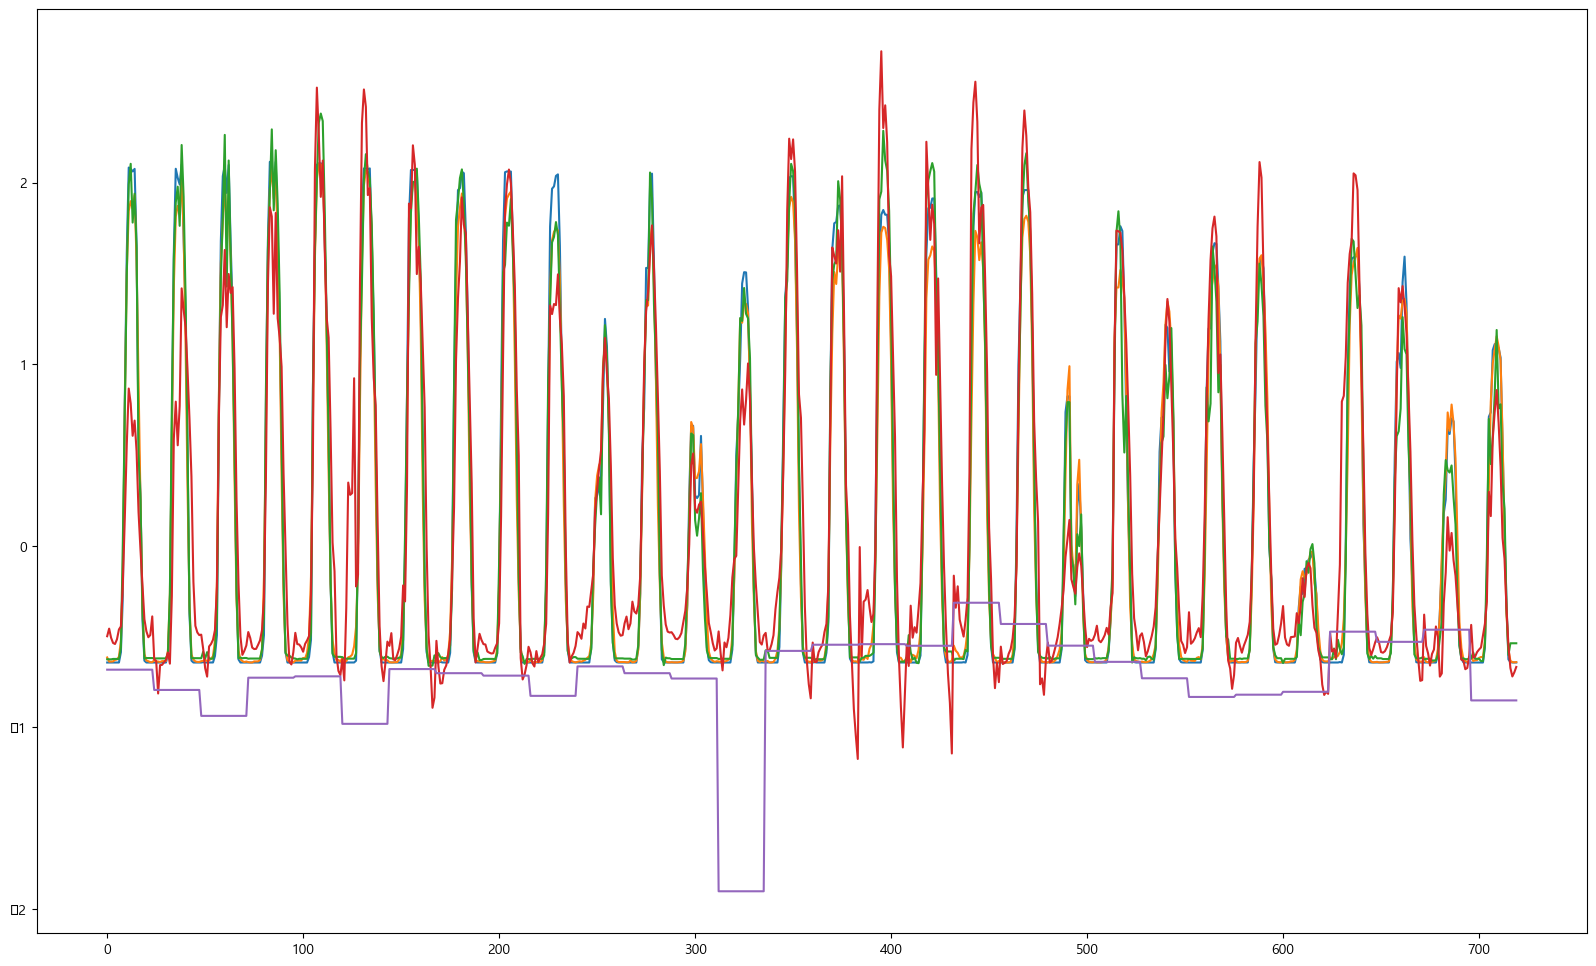

In [50]:
plt.figure(figsize=(20,12))
plt.plot(predictions_list)

In [54]:
from math import *
import random
import sys

In [114]:
class Particle:
    def __init__(self, max_iter, initial_position=None):
        if initial_position:  # If an initial position is provided
            self.position = initial_position.copy()
        else:
            self.position = [0.0]*5  # particle current position
        self.velocity = [random.uniform(-1, 1) for _ in range(24)]  # particle current velocity
        self.best_position = [0.0]*5  # particle best position
        self.fitness = sys.maxsize   # particle fitness
        self.best_fitness = sys.maxsize  # particle best fitness
        self.iteration = 0  # iteration count
        self.max_iter = max_iter

    def evaluate_fitness(self, fitness_func):
        self.fitness = fitness_func(self.position)
        if self.fitness < self.best_fitness:
            self.best_position = self.position.copy()
            self.best_fitness = self.fitness

    def update_velocity(self, global_best_position):
        w_min = 1
        w_max = 2
        self.iteration += 1
        w = w_max - ((w_max - w_min) * self.iteration / self.max_iter)
        c1 = 0.7
        c2 = 1
        for i in range(len(self.position)):
            r1 = random.random()
            r2 = random.random()
            cognitive_velocity = c1 * r1 * (self.best_position[i] - self.position[i])
            social_velocity = c2 * r2 * (global_best_position[i] - self.position[i])
            self.velocity[i] = w * self.velocity[i] + cognitive_velocity + social_velocity

    def update_position(self, bounds):
        for i in range(len(self.position)):
            self.position[i] += self.velocity[i]
            if self.position[i] < bounds[i][0]:
                self.position[i] = bounds[i][0]
            elif self.position[i] > bounds[i][1]:
                self.position[i] = bounds[i][1]

class PSO:
    def __init__(self, fitness_function, bounds, num_particles, max_iter, initial_positions=None):
        self.fitness_func = fitness_function
        self.bounds = bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.global_best_position = [0.0]*24
        self.global_best_fitness = sys.maxsize
        if initial_positions:
            self.swarm = [Particle(max_iter, initial_position=pos) for pos in initial_positions]
        else:
            self.swarm = [Particle(max_iter) for _ in range(num_particles)]

    def run_result(self):
        for i in range(self.max_iter):
            for j in range(self.num_particles):
                self.swarm[j].evaluate_fitness(self.fitness_func)
                if self.swarm[j].fitness < self.global_best_fitness:
                    self.global_best_position = self.swarm[j].position.copy()
                    self.global_best_fitness = self.swarm[j].fitness
            for j in range(self.num_particles):
                self.swarm[j].update_velocity(self.global_best_position)
                self.swarm[j].update_position(self.bounds)
        return self.global_best_position, self.global_best_fitness

lstm_model.fit(x_train[:window_size].reshape(-1, 8, 1), y_train[:window_size], epochs=100, verbose=0)

lstm_predictions_list = []

# 테스트 데이터를 24시간 단위로 이동하면서 예측
for i in tqdm(range(0, len(x_test), 24)):
    x_test_window = x_test[i:i+24].values.reshape(-1, 8, 1)
    y_test_window = y_test[i:i+24]

    predictions_lstm = lstm_model.predict(x_test_window)
    
    # 각 샘플에 대한 예측을 저장
    for j in range(24):
        lstm_predictions_list.append(predictions_lstm[j])

    # 새로운 24시간 데이터를 훈련 데이터에 추가
    x_train = np.concatenate((x_train, x_test_window.reshape(-1, 8)), axis=0)
    y_train = np.concatenate((y_train, y_test_window), axis=0)

    # 새로운 윈도우 크기로 훈련
    lstm_model.fit(x_train[i+24:i+24+window_size].reshape(-1, 8, 1), y_train[i+24:i+24+window_size], epochs=100, verbose=0)

lstm_predictions_array = np.array(lstm_predictions_list)

lstm_predictions_array.shape

plt.plot(lstm_predictions_array.reshape(-1,1)) 

****
# Meta model Train

In [81]:
from sklearn.linear_model import LinearRegression

In [82]:
grid_cv_rf.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
grid_cv_et.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
grid_cv_lg.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
grid_cv_svr.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
auto_arima_model.fit(y_train[:window_size])
#lstm_model.fit(x_train[:window_size].reshape(-1,11,1), y_train[:window_size], epochs=240, batch_size=24)

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [83]:
train_predictions_list = []

# 훈련 데이터에 대한 예측 수집
for i in range(0, len(x_train), 24):
    x_train_window = x_train[i:i+24]

    train_predictions_rf = grid_cv_rf.best_estimator_.predict(x_train_window)
    train_predictions_et = grid_cv_et.best_estimator_.predict(x_train_window)
    train_predictions_lg = grid_cv_lg.best_estimator_.predict(x_train_window)
    train_predictions_svr = grid_cv_svr.best_estimator_.predict(x_train_window)

    # auto_arima_model.fit(y_train[:i+24])
    train_predictions_arima = auto_arima_model.predict(n_periods=len(x_train_window))
    # train_predictions_lstm = lstm_model.predict(x_train_window)

    for j in range(24):
        # train_predictions_list.append([train_predictions_rf[j], train_predictions_et[j], train_predictions_lg[j], train_predictions_lstm[0][j]])
        train_predictions_list.append([train_predictions_rf[j], train_predictions_et[j], train_predictions_lg[j], train_predictions_svr[j], train_predictions_arima[j]])

In [115]:
train_predictions_array = np.array(train_predictions_list)

In [116]:
def fitness_function(x, train_predictions_array, y_train):
    fitness = 0
    for i in range(5):
        fitness += train_predictions_array[:,i] * x[i]
    difference = y_train - fitness
    return np.sum(difference**2)

In [117]:
bound = [(-10,10) for i in range(5)]

In [118]:
pso_result = PSO(lambda x : fitness_function(x, train_predictions_array, y_train), bounds=bound,num_particles=200, max_iter=500 )

In [119]:
best_position_price, best_fitness_price = pso_result.run_result()

In [120]:
best_position_price

[0.7212953994501163,
 -1.5956569101872433,
 1.3441676804109424,
 0.09238148372551447,
 0.6306859811495438]

In [135]:
optimal_result = (train_predictions_array * best_position_price).sum(axis=1)

In [136]:
from sklearn.metrics import mean_absolute_error

In [137]:
mean_absolute_error(y_train, optimal_result)

0.2709729360729897

In [52]:
meta_model = LinearRegression()

In [53]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

In [54]:
meta_model_2 = Sequential()
meta_model_2.add(Dense(128, input_dim=5, activation='relu'))
meta_model_2.add(Dense(128, activation='relu'))
meta_model_2.add(Dense(1))
meta_model_2.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [89]:
meta_loss = meta_model_2.fit(train_predictions_array, y_train, epochs=2400, batch_size=24, verbose=0)

In [56]:
meta_model.fit(train_predictions_array, y_train)

LinearRegression()

In [57]:
meta_model.coef_

array([-0.21823944,  0.07290862,  1.07941699,  0.08063891, -0.02450747])

----
# Meta model prediction

In [58]:
meta_result = meta_model.predict(predictions_array)

In [59]:
meta_result_2 = meta_model_2.predict(predictions_array)

 1/23 [>.............................] - ETA: 1s

23/23 [==============================] - 0s 637us/step


meta_result = meta_model.predict(np.nan_to_num(predictions_array, nan = 0))

In [60]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [61]:
mean_absolute_percentage_error(np.maximum(sc_y.inverse_transform(meta_result.reshape(-1,1)),0), y_test)

724855627129916.2

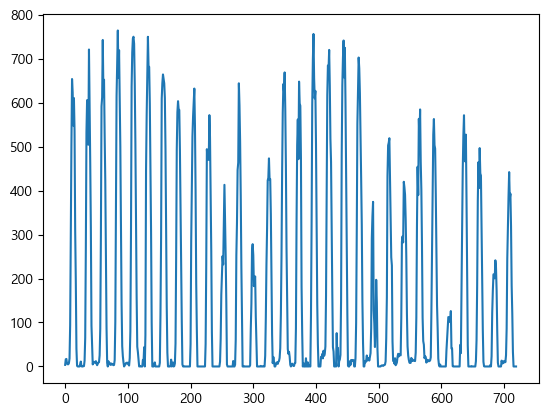

In [62]:
plt.plot(np.maximum(sc_y.inverse_transform(meta_result.reshape(-1,1)),0))

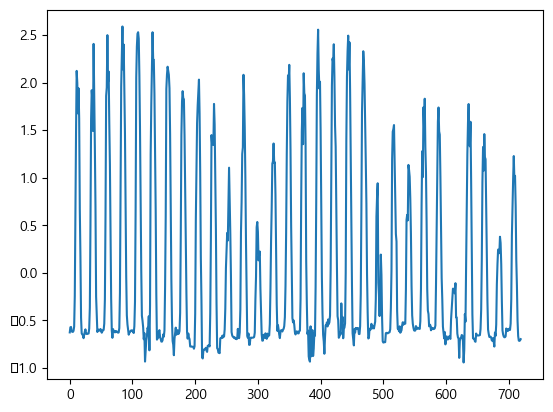

In [63]:
plt.plot(meta_result)

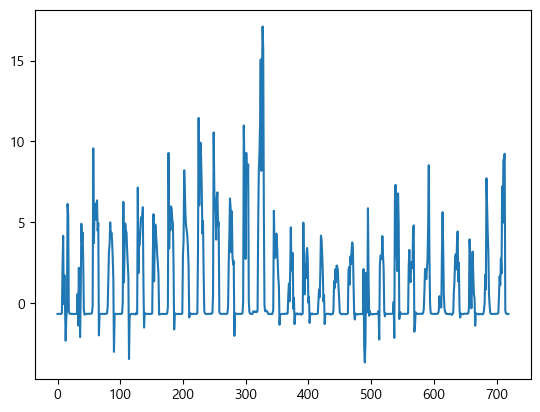

In [64]:
plt.plot(meta_result_2)

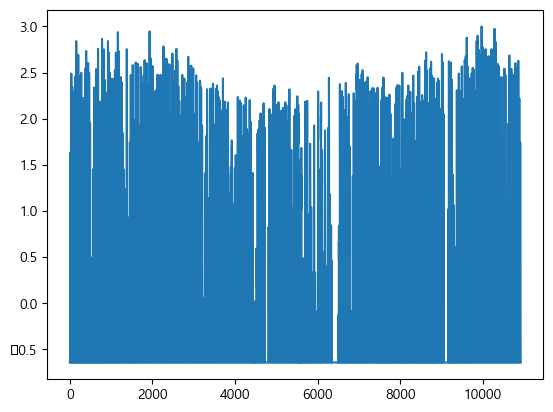

In [65]:
plt.plot(y_train)

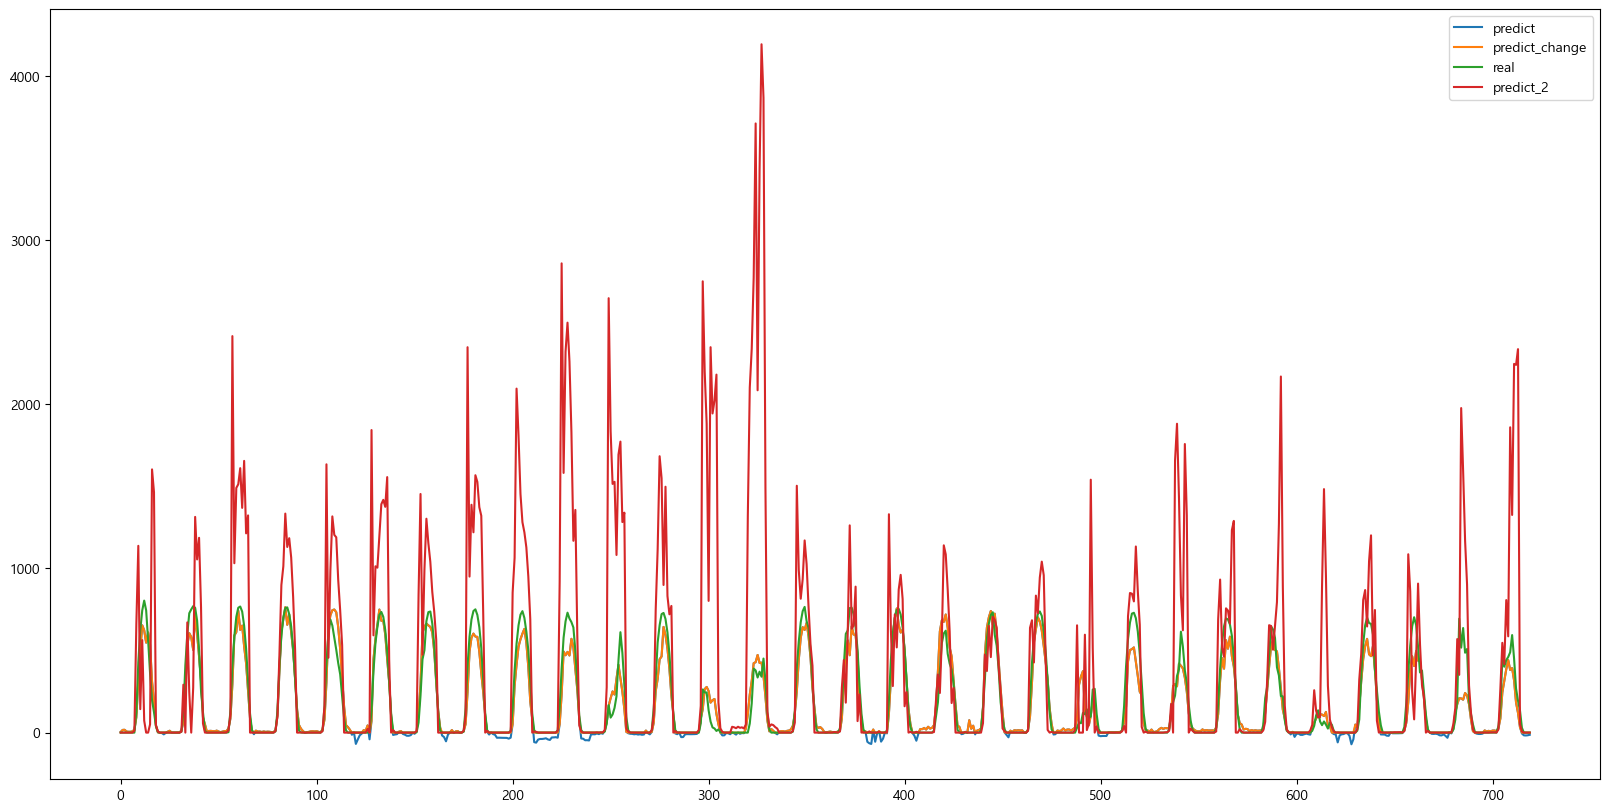

In [66]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(meta_result)), sc_y.inverse_transform(meta_result.reshape(-1,1)), label='predict')
plt.plot(np.arange(len(meta_result)), np.maximum(sc_y.inverse_transform(meta_result.reshape(-1,1)),0), label='predict_change')
plt.plot(np.arange(len(meta_result)), sc_y.inverse_transform(y_test), label='real')
plt.plot(np.arange(len(meta_result)), np.maximum(sc_y.inverse_transform(meta_result_2.reshape(-1,1)),0), label='predict_2')
plt.legend()
plt.show()

In [67]:
mean_squared_error(y_test, meta_result)

0.1193042466298439

In [68]:
mean_absolute_error(y_test, meta_result)

0.21569059453377276

In [69]:
mean_absolute_error(y_test[:24], meta_result[:24])

0.2176061758768207

In [70]:
predictions_array

array([[-0.64253851, -0.64253579, -0.63930858, -0.49777629, -0.68195055],
       [-0.64253851, -0.64253851, -0.59273037, -0.4559411 , -0.68195055],
       [-0.64253851, -0.64253851, -0.58588635, -0.50651444, -0.68195055],
       ...,
       [-0.64253851, -0.64251046, -0.70931461, -0.71938466, -0.85125256],
       [-0.64253851, -0.64253337, -0.70615282, -0.69670215, -0.85125256],
       [-0.64253851, -0.64253337, -0.69647434, -0.66700552, -0.85125256]])

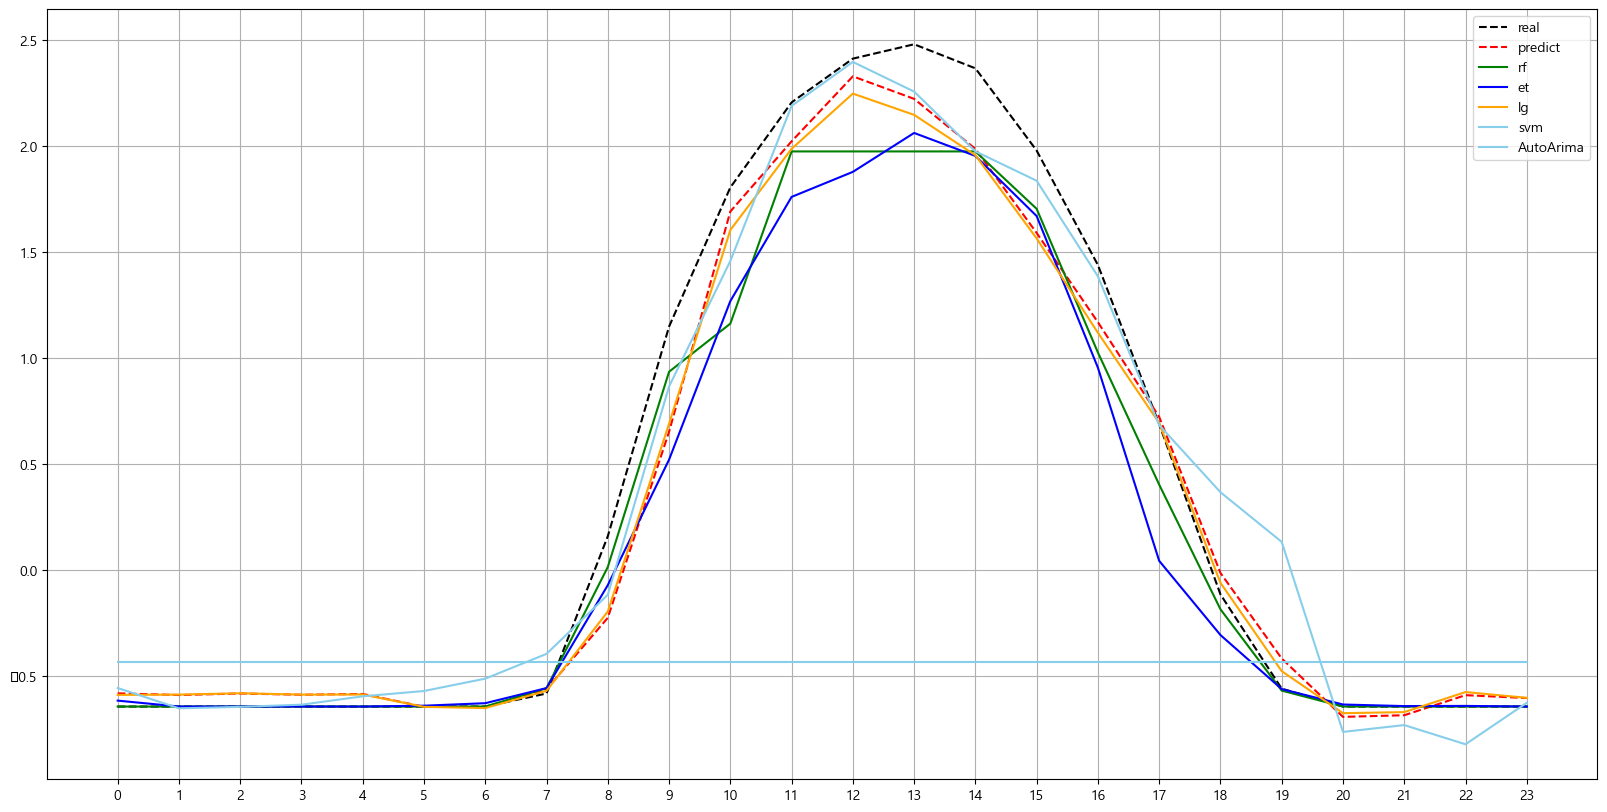

0.13893379284316326

In [71]:
i = 19
plt.figure(figsize=(20,10))
plt.plot(np.arange(24), y_test[i * 24 : 24*(i+1)], 'k--')
plt.plot(np.arange(24), meta_result[i * 24 : 24*(i+1)], 'r--')

plt.plot(np.arange(24), pd.DataFrame(predictions_array).iloc[i * 24 : 24*(i+1),0], color = 'green')
plt.plot(np.arange(24), pd.DataFrame(predictions_array).iloc[i * 24 : 24*(i+1),1], color = 'blue')
plt.plot(np.arange(24), pd.DataFrame(predictions_array).iloc[i * 24 : 24*(i+1),2], color = 'orange')
plt.plot(np.arange(24), pd.DataFrame(predictions_array).iloc[i * 24 : 24*(i+1),3], color = 'skyblue')
plt.plot(np.arange(24), pd.DataFrame(predictions_array).iloc[i * 24 : 24*(i+1),4], color = 'skyblue')

plt.legend(['real','predict', 'rf', 'et', 'lg', 'svm', 'AutoArima'])
plt.xticks(np.arange(24))
plt.grid()
plt.show()

mean_absolute_error(y_test[i * 24 : 24*(i+1)], meta_result[i * 24 : 24*(i+1)])

# MAP